# Hierarchical Sampling Model - FIXED VERSION

With numerical stability improvements to prevent NaN values during training.

## 1. Libraries

In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import scipy
from scipy.stats import normal_inverse_gamma, invgamma
from tqdm import trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import zarr

print(f'PyTorch: {torch.__version__}')
print(f'CUDA: {torch.cuda.is_available()}')

PyTorch: 2.9.1+cu128
CUDA: True


## 2. Data Generation

In [2]:
N = 4
n_samples = 2
dataset_size = 10000

def gen_zarr(N, n_samples, dataset_size):
    dataset_zarr = zarr.open_array(
        'data/x_train.zarr', mode='w',
        shape=(dataset_size, n_samples + 1, N),
        chunks=(10, n_samples + 1, N),
        dtype='float32'
    )
    return dataset_zarr

dataset_zarr = gen_zarr(N, n_samples, dataset_size)
print(f"Created Zarr array: {dataset_zarr.shape}")

Created Zarr array: (10000, 3, 4)


In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def my_sample_from_gamma(x):
    inv_gamma = normal_inverse_gamma(*x)
    x_ = inv_gamma.rvs()[0]
    return x_

sample_from_gamma = np.vectorize(my_sample_from_gamma, signature="(n)->()")

def gen_X_train(N, dataset_size, rng, rng2, rng3, rng4, dataset_zarr):
    nu_seed = rng.random((N, 1))
    alpha_seed = 13 * rng.beta(rng2.random(), rng2.random(), size=(N, 1))
    mu_loc = [
        np.random.choice(np.array([-1, -0.5, 0.6, 0.3, 1]))
        * np.random.beta(np.random.random(), np.random.random())
        for _ in range(N)
    ]
    mu_scale = [np.random.beta(np.random.random(), np.random.random()) for _ in range(N)]
    
    mu_seed = rng.normal(loc=mu_loc, scale=mu_scale, size=(N, N))
    mu_seed = np.diagonal(mu_seed)[None].T
    lambda_seed = rng2.random((N, 1))
    beta_seed = rng3.random((N, 1))
    
    params = np.hstack([mu_seed, lambda_seed, alpha_seed, beta_seed])
    for _ in trange(dataset_size, desc='Generating X'):
        params_ = params.copy()
        x = sample_from_gamma(params_)
        dataset_zarr[_, 0] = x
    return dataset_zarr

rng = default_rng(34)
rng2 = default_rng(np.random.randint(1, 3090))
rng3 = default_rng(np.random.randint(1, 3090))
rng4 = default_rng(np.random.randint(1, 3090))

dataset_zarr = gen_X_train(N, dataset_size, rng, rng2, rng3, rng4, dataset_zarr)
print("X generation complete!")

Generating X:   0%|          | 0/10000 [00:00<?, ?it/s]/home/arjun/TTS/.venv/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:4937: RuntimeWarning: divide by zero encountered in scalar divide
  return 1.0 / sc.gammainccinv(a, q)
/home/arjun/TTS/.venv/lib/python3.13/site-packages/zarr/core/array.py:1673: RuntimeWarning: overflow encountered in cast
  value = value.astype(dtype=self.dtype, order="A")
Generating X:   1%|          | 95/10000 [00:00<00:42, 235.83it/s]/home/arjun/TTS/.venv/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:4937: RuntimeWarning: overflow encountered in scalar divide
  return 1.0 / sc.gammainccinv(a, q)
Generating X: 100%|██████████| 10000/10000 [00:42<00:00, 235.73it/s]

X generation complete!


## 3. Kernel Functions

In [4]:
def mixture_kernel_sampler(x):
    mu_1 = 2 * x**2 + 1
    mu_2 = -2 * x**2 - 1
    sigma = 0.3 * np.abs(np.sin(4 * x)) + 0.05
    prob_mode_1 = 1 / (1 + np.exp(-5 * x))
    mode_choice = np.random.rand() < prob_mode_1
    return np.random.normal(loc=mu_1 if mode_choice else mu_2, scale=sigma)

def hierarchical_nig_sampler(x):
    gamma = 3 * x
    nu = np.abs(x) + 1.0
    alpha = min(2.0 + np.exp(-0.5 * x**3), 100.0)  # Prevent overflow
    beta = 0.5
    sigma_sq = invgamma.rvs(a=alpha, scale=beta)
    mean_variance = sigma_sq / nu
    sampled_mu = np.random.normal(loc=gamma, scale=np.sqrt(mean_variance)) * x
    return np.random.normal(loc=sampled_mu, scale=np.sqrt(sigma_sq))

def jump_diffusion_sampler(x):
    drift = np.sin(3 * x)
    diffusion_noise = np.random.normal(0, 0.2)
    jump_prob = 0.05 + 0.4 * (np.abs(x) > 1.5)
    is_jump = np.random.rand() < jump_prob
    jump_val = (np.random.choice([-2, 2]) + np.random.normal(0, 0.5)) if is_jump else 0
    return drift + diffusion_noise + jump_val

def fractal_weierstrass_sampler(x, K=10):
    b = 2.0 + 0.5 * np.sin(x)
    a = 0.5 / (1 + np.abs(x))
    y_sum = sum((a**k) * np.cos((b**k) * np.pi * x + np.random.uniform(0, 2*np.pi)) for k in range(K))
    return y_sum + np.random.normal(0, 0.05)

def stochastic_volatility_jump_sampler(x):
    mu, base_vol, jump_prob = (0.5*x, 0.1, 0.4) if x > 0 else (0.5*x, 0.4, 0.2)
    realized_vol = base_vol * np.exp(np.random.normal(0, 0.2))
    is_jump = np.random.rand() < jump_prob
    jump_size = np.random.normal(-2.0, 0.5) if is_jump else 0
    return mu + np.random.normal(0, realized_vol) + jump_size

print("Kernels defined!")

Kernels defined!


## 4. Target Generation

In [5]:
kernel_funcs = [mixture_kernel_sampler, hierarchical_nig_sampler, jump_diffusion_sampler, 
                 stochastic_volatility_jump_sampler, fractal_weierstrass_sampler]
kernel_pos = np.random.choice(kernel_funcs, size=(N,), replace=False)

def gen_targets(x, n_samples):
    y_targets = []
    for _ in range(n_samples):
        target = [kernel_pos[i](x[i]) for i in range(4)]
        y_targets.append(target)
    return y_targets

for i in trange(dataset_size, desc='Generating targets'):
    _x = dataset_zarr[i, 0]
    targets = gen_targets(_x, n_samples)
    for j in range(n_samples):
        dataset_zarr[i, j+1] = targets[j]

print(f"Dataset complete: {dataset_zarr.shape}")

Generating targets:   0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_35873/3326496722.py:4: RuntimeWarning: invalid value encountered in sin
  sigma = 0.3 * np.abs(np.sin(4 * x)) + 0.05
/tmp/ipykernel_35873/3326496722.py:20: RuntimeWarning: invalid value encountered in sin
  drift = np.sin(3 * x)
/tmp/ipykernel_35873/3326496722.py:28: RuntimeWarning: invalid value encountered in sin
  b = 2.0 + 0.5 * np.sin(x)
/tmp/ipykernel_35873/3326496722.py:30: RuntimeWarning: invalid value encountered in cos
  y_sum = sum((a**k) * np.cos((b**k) * np.pi * x + np.random.uniform(0, 2*np.pi)) for k in range(K))
Generating targets:   4%|▎         | 369/10000 [00:00<00:21, 448.61it/s]/tmp/ipykernel_35873/3326496722.py:30: RuntimeWarning: overflow encountered in scalar multiply
  y_sum = sum((a**k) * np.cos((b**k) * np.pi * x + np.random.uniform(0, 2*np.pi)) for k in range(K))
Generating targets: 100%|██████████| 10000/10000 [00:22<00:00, 446.20it/s]

Dataset complete: (10000, 3, 4)


## 5. Model - FIXED for Numerical Stability

In [6]:
def sampling_nll_loss(y_true, mu, lmbda, alpha, beta):
    '''Numerically stable NLL loss with safety checks'''
    eps = 1e-4
    
    # Clamp parameters to safe ranges
    lmbda = torch.clamp(lmbda, min=eps, max=100.0)
    alpha = torch.clamp(alpha, min=1.5, max=50.0)
    beta = torch.clamp(beta, min=eps, max=50.0)
    
    two_beta_lambda = 2 * beta * (1 + lmbda)
    
    # Compute each term separately with safety
    term1 = 0.5 * torch.log(torch.tensor(np.pi, device=lmbda.device) / lmbda)
    term2 = alpha * torch.log(two_beta_lambda)
    
    # Clamp squared error to prevent extreme values
    squared_error = torch.clamp((y_true - mu) ** 2, min=eps, max=1e4)
    term3 = (alpha + 0.5) * torch.log(lmbda * squared_error + two_beta_lambda)
    
    term4 = torch.lgamma(alpha) - torch.lgamma(alpha + 0.5)
    
    nll = term1 - term2 + term3 + term4
    
    # Replace any NaN with large finite value
    nll = torch.where(torch.isnan(nll) | torch.isinf(nll), 
                      torch.tensor(100.0, device=nll.device), nll)
    
    return nll.mean()

def sampling_regularization(y_true, mu, lmbda, alpha, beta):
    '''Regularization with bounds'''
    error = torch.clamp(torch.abs(y_true - mu), max=10.0)
    evidence = 2 * lmbda + alpha
    return (error * evidence).mean()

def total_sampling_loss(y_true, mu, lmbda, alpha, beta, reg_coeff=0.001):
    '''Combined loss with NaN protection'''
    loss_nll = sampling_nll_loss(y_true, mu, lmbda, alpha, beta)
    loss_reg = sampling_regularization(y_true, mu, lmbda, alpha, beta)
    total = loss_nll + reg_coeff * loss_reg
    
    # Final safety check
    if torch.isnan(total) or torch.isinf(total):
        return torch.tensor(100.0, device=total.device, requires_grad=True)
    
    return torch.clamp(total, max=1000.0)

print("Loss functions defined with numerical stability!")

Loss functions defined with numerical stability!


In [7]:
class SamplingModule(nn.Module):
    def __init__(self, feature_dim=4, hidden_dim=64):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.proj_mu = nn.Linear(hidden_dim, feature_dim)
        self.proj_lmbda = nn.Linear(hidden_dim, feature_dim)
        self.proj_alpha = nn.Linear(hidden_dim, feature_dim)
        self.proj_beta = nn.Linear(hidden_dim, feature_dim)
        
        # Conservative initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.3)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.01)
    
    def forward(self, x):
        # NaN protection on input
        x = torch.nan_to_num(x, nan=0.0, posinf=10.0, neginf=-10.0)
        
        h = self.backbone(x)
        
        # Bounded predictions
        mu = torch.tanh(self.proj_mu(h)) * 3.0  # Range: [-3, 3]
        lmbda = torch.sigmoid(self.proj_lmbda(h)) * 10.0 + 0.5  # Range: [0.5, 10.5]
        alpha = torch.sigmoid(self.proj_alpha(h)) * 10.0 + 2.0  # Range: [2, 12]
        beta = torch.sigmoid(self.proj_beta(h)) * 5.0 + 0.5   # Range: [0.5, 5.5]
        
        return mu, lmbda, alpha, beta
    
    def sample_hierarchical(self, x):
        mu_pred, lmbda_pred, alpha_pred, beta_pred = self.forward(x)
        
        eps = 1e-4
        try:
            gamma_dist = torch.distributions.Gamma(
                torch.clamp(alpha_pred, min=eps), 
                torch.clamp(beta_pred, min=eps)
            )
            sigma_2_sample = 1.0 / (gamma_dist.sample() + eps)
            sigma_2_sample = torch.clamp(sigma_2_sample, min=eps, max=50.0)
            
            mean_std = torch.sqrt(sigma_2_sample / torch.clamp(lmbda_pred, min=eps))
            mean_dist = torch.distributions.Normal(mu_pred, mean_std)
            mu_sample = mean_dist.sample()
            
            final_dist = torch.distributions.Normal(mu_sample, torch.sqrt(sigma_2_sample))
            y_sample = final_dist.sample()
            
            return torch.clamp(y_sample, min=-50.0, max=50.0)
        except:
            return mu_pred  # Fallback to mean if sampling fails
        
print("Model defined!")

Model defined!


## 6. Train/Val/Test Split

In [8]:
total_size = dataset_zarr.shape[0]
indices = np.arange(total_size)
np.random.seed(42)
np.random.shuffle(indices)

train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

Train: 8000, Val: 1000, Test: 1000


In [9]:
class IndexedTripletDataset(Dataset):
    def __init__(self, data_source, indices):
        self.data = data_source
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        sample = self.data[actual_idx]
        x, y1, y2 = sample[0:1, :], sample[1:2, :], sample[2:3, :]
        
        # Clean data - replace NaN/Inf
        x = np.nan_to_num(x, nan=0.0, posinf=10.0, neginf=-10.0)
        y1 = np.nan_to_num(y1, nan=0.0, posinf=10.0, neginf=-10.0)
        y2 = np.nan_to_num(y2, nan=0.0, posinf=10.0, neginf=-10.0)
        
        return x, y1, y2

train_dataset = IndexedTripletDataset(dataset_zarr, train_indices)
val_dataset = IndexedTripletDataset(dataset_zarr, val_indices)
test_dataset = IndexedTripletDataset(dataset_zarr, test_indices)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"DataLoaders ready!")

DataLoaders ready!


## 7. Training with NaN Protection

In [15]:
def train_epoch(model, dataloader, optimizer, device='cpu'):
    model.train()
    total_loss = total_loss1 = total_loss2 = 0.0
    num_batches = 0
    
    for x, y1, y2 in dataloader:
        x = x.squeeze(1).float().to(device)
        y1 = y1.squeeze(1).float().to(device)
        y2 = y2.squeeze(1).float().to(device)
        
        optimizer.zero_grad()
        
        mu1, l1, a1, b1 = model(x)
        loss1 = total_sampling_loss(y1, mu1, l1, a1, b1)
        
        # mu2, l2, a2, b2 = model(x)
        loss2 = total_sampling_loss(y2, mu1, l1, a1, b1)
        
        loss = loss1 + loss2
        
        if not (torch.isnan(loss) or torch.isinf(loss)):
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            total_loss1 += loss1.item()
            total_loss2 += loss2.item()
            num_batches += 1
    
    if num_batches == 0:
        return 0.0, 0.0, 0.0
    
    return total_loss/num_batches, total_loss1/num_batches, total_loss2/num_batches

def validate_epoch(model, dataloader, device='cpu'):
    model.eval()
    total_loss = total_loss1 = total_loss2 = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for x, y1, y2 in dataloader:
            x = x.squeeze(1).float().to(device)
            y1 = y1.squeeze(1).float().to(device)
            y2 = y2.squeeze(1).float().to(device)
            
            mu1, l1, a1, b1 = model(x)
            loss1 = total_sampling_loss(y1, mu1, l1, a1, b1)
            
            # mu2, l2, a2, b2 = model(x)
            loss2 = total_sampling_loss(y2, mu1, l1, a1, b1)
            
            loss = loss1 + loss2
            
            if not (torch.isnan(loss) or torch.isinf(loss)):
                total_loss += loss.item()
                total_loss1 += loss1.item()
                total_loss2 += loss2.item()
                num_batches += 1
    
    if num_batches == 0:
        return 0.0, 0.0, 0.0
    
    return total_loss/num_batches, total_loss1/num_batches, total_loss2/num_batches

print("Training functions ready!")

Training functions ready!


In [16]:
# Check data before training
print("Data validation:")
sample_check = dataset_zarr[:100, :, :]
print(f"  NaN count: {np.isnan(sample_check).sum()}")
print(f"  Inf count: {np.isinf(sample_check).sum()}")
print(f"  Range: [{np.nanmin(sample_check):.2f}, {np.nanmax(sample_check):.2f}]")

# Initialize
model = SamplingModule(feature_dim=4, hidden_dim=64)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print(f"\nDevice: {device}")
print(f"Learning rate: 0.0001 (stable)")
print(f"Gradient clipping: 1.0")

Data validation:
  NaN count: 590
  Inf count: 595
  Range: [-inf, inf]

Device: cuda
Learning rate: 0.0001 (stable)
Gradient clipping: 1.0


In [17]:
num_epochs = 30
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_loss1, train_loss2 = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_loss1, val_loss2 = validate_epoch(model, val_loader, device)
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    print(f"  Train: {train_loss:.4f} (y1: {train_loss1:.4f}, y2: {train_loss2:.4f})")
    print(f"  Val:   {val_loss:.4f} (y1: {val_loss1:.4f}, y2: {val_loss2:.4f})")
    
    if val_loss < best_val_loss and val_loss > 0:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  ✓ Saved! Best: {best_val_loss:.4f}")

print(f"\nTraining complete! Best val loss: {best_val_loss:.4f}")


Epoch 1/30


  Train: 10.3636 (y1: 5.1824, y2: 5.1812)
  Val:   7.5893 (y1: 3.7967, y2: 3.7926)
  ✓ Saved! Best: 7.5893

Epoch 2/30
  Train: 5.1585 (y1: 2.5790, y2: 2.5795)
  Val:   3.8652 (y1: 1.9352, y2: 1.9300)
  ✓ Saved! Best: 3.8652

Epoch 3/30
  Train: 3.6855 (y1: 1.8414, y2: 1.8442)
  Val:   3.5991 (y1: 1.8018, y2: 1.7973)
  ✓ Saved! Best: 3.5991

Epoch 4/30
  Train: 3.5702 (y1: 1.7853, y2: 1.7849)
  Val:   3.5569 (y1: 1.7805, y2: 1.7764)
  ✓ Saved! Best: 3.5569

Epoch 5/30
  Train: 3.5330 (y1: 1.7664, y2: 1.7666)
  Val:   3.5464 (y1: 1.7752, y2: 1.7712)
  ✓ Saved! Best: 3.5464

Epoch 6/30
  Train: 3.5421 (y1: 1.7714, y2: 1.7708)
  Val:   3.5923 (y1: 1.7952, y2: 1.7971)

Epoch 7/30
  Train: 3.5396 (y1: 1.7692, y2: 1.7704)
  Val:   3.5456 (y1: 1.7748, y2: 1.7707)
  ✓ Saved! Best: 3.5456

Epoch 8/30
  Train: 3.5228 (y1: 1.7599, y2: 1.7629)
  Val:   3.5708 (y1: 1.7854, y2: 1.7854)

Epoch 9/30
  Train: 3.5396 (y1: 1.7695, y2: 1.7700)
  Val:   3.5741 (y1: 1.7872, y2: 1.7869)

Epoch 10/30
  Train:

## 8. Results

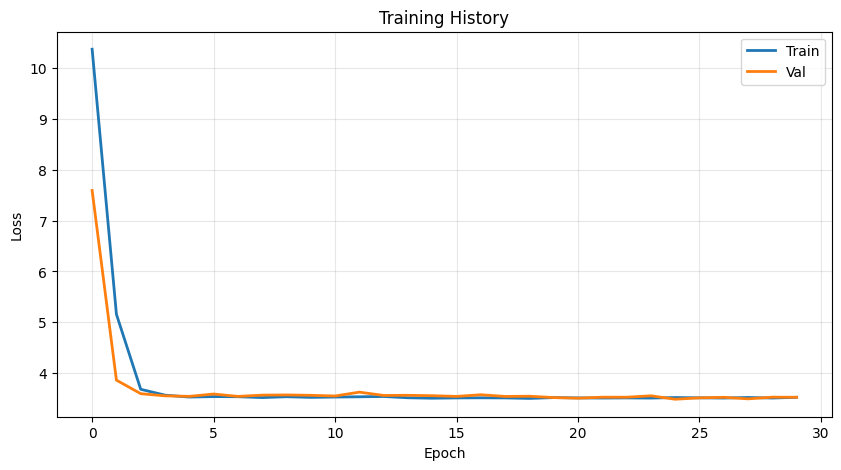


Test Loss: 3.5212
  Y1: 1.7607
  Y2: 1.7605


In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train', linewidth=2)
plt.plot(history['val_loss'], label='Val', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('training_history.png', dpi=150)
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_loss1, test_loss2 = validate_epoch(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"  Y1: {test_loss1:.4f}")
print(f"  Y2: {test_loss2:.4f}")